In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

import os
from datetime import datetime, timedelta

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

In [2]:
def correct_angles(data):
    correction_up = [0]  # This variable will store the accumulated correction value
    correction_down = [0]
    up=0
    down=0
    for i in range(1, len(data)):
        difference = data[i] - data[i-1]
        
        # If jump from ~360 to 0
        if difference < -180:
            up+=1
        
            
        # If jump from ~0 to 360
        elif difference > 180:
            
            down+=1
        
        # Apply correction
        correction_up.append(up)
        correction_down.append(down)
        
    return (correction_up, correction_down)

def round_and_avoid_duplicates(data):
    # Round to the nearest 10
    rounded = np.rint(data / 10.0) * 10
    
    # For each unique element, calculate its adjusted value
    output = np.zeros_like(rounded)
    unique_vals, counts = np.unique(rounded, return_counts=True)
    
    for val, count in zip(unique_vals, counts):
        indices = np.where(rounded == val)[0]
        adjustments = np.arange(count) * 10
        output[indices] = val + adjustments

    return output

def linear_regression_detrend(y):
    """
    Uses linear regression to detrend the data.
    Returns the detrended data.
    """
    X = np.arange(len(y)).reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    
    # Predicted trend
    trend = model.predict(X)
    
    # Detrended data
    detrended = y - trend
    return detrended
    
def normalize_to_range(data, a=-1, b=1):
    X_min = np.min(data)
    X_max = np.max(data)
    
    normalized_data = a + (data - X_min) * (b - a) / (X_max - X_min)
    
    return normalized_data

def filename_to_datetime(filename):
    """
    Converts the filename convention to a datetime object.
    """
    # Remove the file extension and split into components
    components = filename.split('.')[0].split('-')
    month, day, hour, minute, second = map(int, components)
    
    current_year = datetime.now().year
    dt = datetime(current_year, month, day, hour, minute, second)
    return dt

def read_and_adjust_timestamps(directory, filename):
    """
    Reads the file and adjusts the timestamps based on the filename.
    """
    path = os.path.join(directory, filename)
    data = pd.read_csv(path, skiprows=1, delimiter='\t', header=None).to_numpy()

    initial_dt = filename_to_datetime(filename)
    # Adjust timestamps using timedelta
    adjusted_timestamps = [initial_dt + timedelta(seconds=float(t/1000)) for t in (data[:, 0]-data[0, 0])]
    
    return adjusted_timestamps, data[:, 1:]

def concatenate_files(directory):
    """
    Loops over files in directory, adjusts their timestamps, and concatenates them.
    """
    all_timestamps = []
    all_data = []

    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.txt'):
            timestamps, data = read_and_adjust_timestamps(directory, filename)
            all_timestamps.extend(timestamps)
            all_data.extend(data)

    all_data = np.array(all_data)
    y = all_data[:, 0]
    p = all_data[:, 1]
    r = all_data[:, 2]

    return all_timestamps, y, p, r


In [3]:
directory = '../dataset/orientation/test'
paths = os.listdir(directory)

path = paths[0]
data = pd.read_csv(os.path.join(directory, path),
                    skiprows=1,
                    delimiter='\t',
                    header=None).to_numpy()
timestamp = data[:, 0]-data[0, 0]
# timestamp = np.around(timestamp)
timestamp = round_and_avoid_duplicates(timestamp)
y = data[:, 1]
p = data[:, 2]
r = data[:, 3]

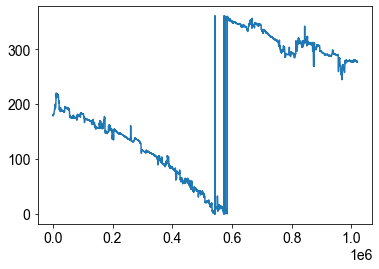

In [4]:
# sos = signal.butter(3, 1, btype='bandpass', output='sos', fs=100)
# y_f = signal.sosfilt(sos, y)
# y_dt = moving_difference_detrend(y, window=3)
y_n = normalize_to_range(y)
p_n = normalize_to_range(p)
r_n = normalize_to_range(r)

plt.plot(timestamp, y)
# plt.plot(timestamp, p_n)
# plt.plot(timestamp, r_n)
# plt.xlim(0, 100000)
# plt.ylim(-1, 1)

In [5]:
timestamps, y, p, r = concatenate_files(directory)

timestamp_or = [(ts - timestamps[0]).total_seconds() for ts in timestamps]
timestamp_or = np.array(np.around(timestamp_or, 2))

# y_c = correct_angles(y)

y_n = normalize_to_range(y)
p_n = normalize_to_range(p)
r_n = normalize_to_range(r)

PV

In [6]:
filename = '../dataset/pv/20230706/long_test_0713_no_comment.txt'
data = pd.read_csv(filename,
                   skiprows=6,
                   delimiter='\t',
                   header=None,
                   comment='#').to_numpy()
timestamp_pv = data[:, 0]
c = data[:, 1]
b = data[:, 2]
tl = data[:, 3]
tr = data[:, 4]

In [7]:
def remove_spikes(data,bound):
    data[0]=data[1]
    noise=[index for index, value in enumerate(data) if value<bound or value>370]
    normal=[index for index, value in enumerate(data) if value>=bound and value<=370]
    print(np.mean(data[normal]))
    data[noise]=np.mean(data[normal])
    # for i in range(1,len(data)):
    #     if data[i]<250 or data[i]>370:
    #         data[i]=np.mean(data[i-300000:i])
    #     data[0]=data[1]
    return data
        # print(np.mean(tr[i-300000:i]))
    # end=[]

    # noise=[index for index, value in enumerate(data) if value<50]
    # diff=np.diff(noise[1:])
    # start=[noise[1]]

    # for i in range(len(diff)-1):
    #     if diff[i]>1:
    #         end.append(noise[i-1])
    #         start.append(noise[i])
    # end.append(noise[-1])
    
    # for s, e in zip(start,end):
    #     for j in range(s,e+1):
    #         slope=(data[e+1]-data[s-1])/(e-s+2)
    #         new_data[j]+=slope*(j-s+1)+data[s-1]
    
    # return (start,end)

# plt.plot(tr[759003:760000])
# plt.plot(remove_spikes(tr))
# start, end = remove_spikes(tr)
# for i in range(len(start)):
#     print(start[i]-end[i])



333.48422274899104
334.77864709232824
348.10868310896757
345.71744268156317


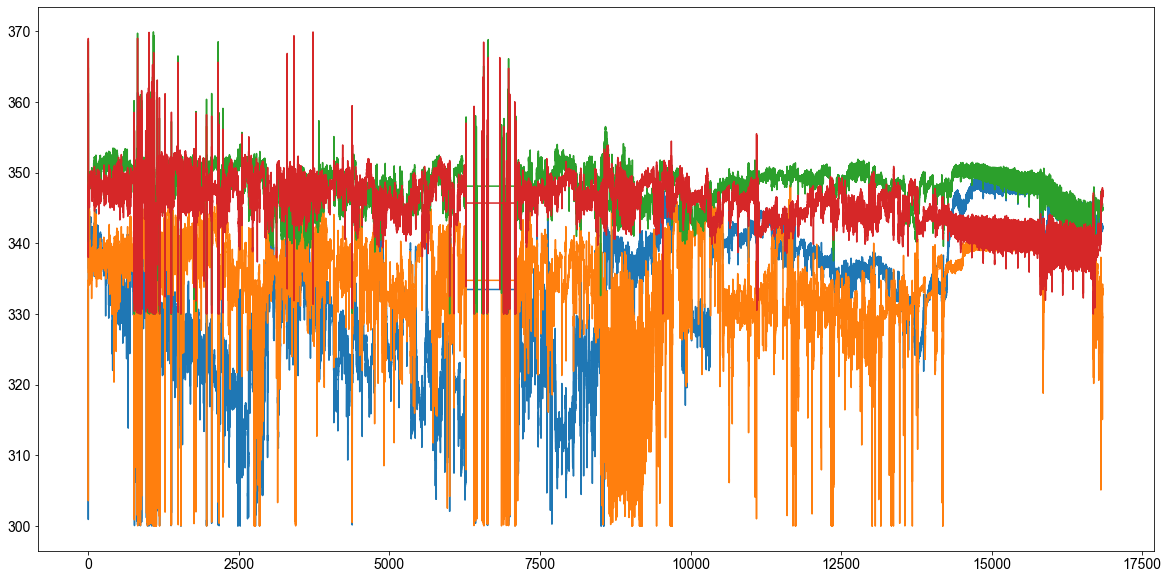

In [8]:
d, a = signal.butter(2, 30, fs=1000)
pv_c_f = signal.filtfilt(d, a, c)
pv_b_f = signal.filtfilt(d, a, b)
pv_tl_f = signal.filtfilt(d, a, tl)
pv_tr_f = signal.filtfilt(d, a, tr)
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot()
ax.plot(timestamp_pv, remove_spikes(pv_c_f,300))
ax.plot(timestamp_pv, remove_spikes(pv_b_f,300))
ax.plot(timestamp_pv, remove_spikes(pv_tl_f,330))
ax.plot(timestamp_pv, remove_spikes(pv_tr_f,330))

In [9]:
# new_data=tl
# end=[]

# noise=[index for index, value in enumerate(tl) if value<250]
# diff=np.diff(noise[1:])
# start=[noise[1]]

# for i in range(len(diff)-1):
#     if diff[i]>1:
#         end.append(noise[i+1])
#         start.append(noise[i+2])
# end.append(noise[-1])
# print(len(start))

# for i in range(len(start)//10):
#     s=start[i]
#     e=end[i]
#     slope=(new_data[e+1]-new_data[s-1])/(e-s+2)
#     print(slope)
#     print(new_data[e+1])
#     print(new_data[s-1])

#     for j in range(s,e+1):
#         # if j not in noise:
#         #     print("not")
#         # if tl[s-1]<300:
#         #     print("not")

#         new_data[j]=tl[j]+tl[s-1]
#         # if new_data[j]<300:
#         #     print("not")
#         #     print(tl[s-1])
#     new_data[0]=new_data[1]


# plt.plot(new_data)


# plt.plot(tr)
# plt.plot(remove_spikes(tr))
# s,e=remove_spikes(tr)


In [10]:
directory = '../dataset/orientation/test'
paths = sorted(os.listdir(directory))
dataset=[]
y_n = []
prev_correction=0

for i in range(len(paths)):
    data = pd.read_csv(os.path.join(directory, paths[i]),
                    skiprows=1,
                    delimiter='\t',
                    header=None).to_numpy()

    # timestamp = np.around(timestamp)
    # timestamp = round_and_avoid_duplicates(timestamp)
    y = data[:, 1]

    if i==0:
        y_n.extend(y[:42235])
        y=y[42235:]
    up, down = correct_angles(y)
    print(len(y))
    print(len(up))
    for j in range(len(y)):
        y[j] += 360*(up[j]-down[j])
    y_d = linear_regression_detrend(y)       
    y_n.extend(y_d)
# y_n = normalize_to_range(np.array(y_n))
# for i in range(len(y_n)):
#     if y_n[i] > -0.95:
#         y_n[i]=y_n[i-1]
# plt.plot(timestamp_or,y_n)


41495
41495
254613
254613
183719
183719
113931
113931
220982
220982
297844
297844
254341
254341


In [11]:
for i in range(len(r_n)):
    if r_n[i] > -0.5:
        r_n[i]=r_n[i-1]

y_n=normalize_to_range(y_n)

for i in range(len(y_n)):
    if y_n[i] > 0.9:
        y_n[i]=y_n[i-1]

333.48422274899184
334.7786470923287
348.10868310896933
345.71744268156164


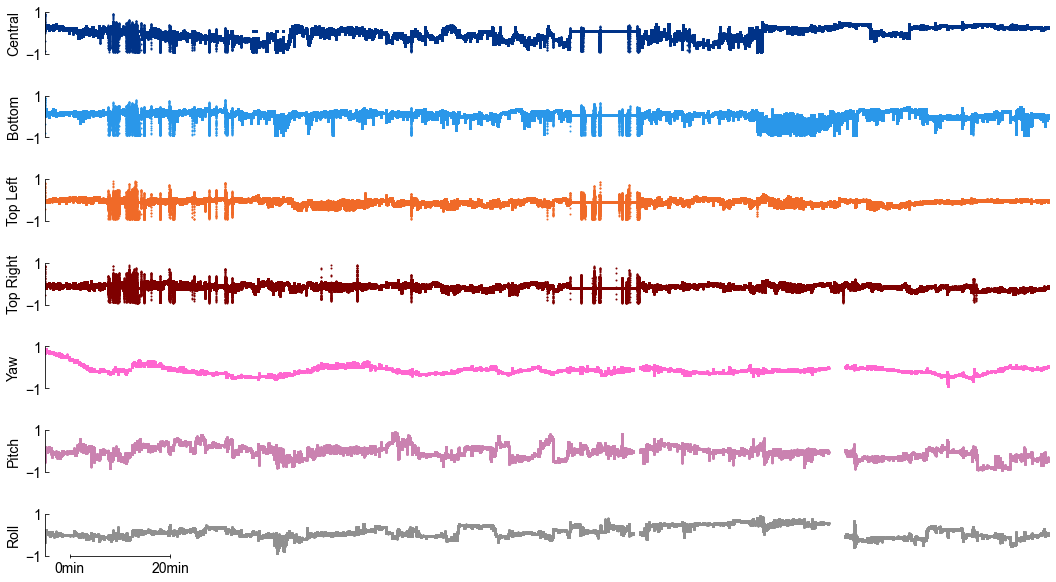

In [12]:
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
labels = ['Central', 'Bottom', 'Top Left', 'Top Right', 'Yaw', 'Pitch', 'Roll']

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=[18, 10], sharex=True, sharey=True)
fig.subplots_adjust(hspace=1)

axes[0].plot(timestamp_pv, 0.9*normalize_to_range(remove_spikes(pv_c_f,300)), linestyle='None', marker='o', markerfacecolor=pv_color[0], mew=0, ms=2)
axes[1].plot(timestamp_pv, 0.9*normalize_to_range(remove_spikes(pv_b_f,300)), linestyle='None', marker='o', markerfacecolor=pv_color[1], mew=0, ms=2)
axes[2].plot(timestamp_pv, 0.9*normalize_to_range(remove_spikes(pv_tl_f,330)), linestyle='None', marker='o', markerfacecolor=pv_color[2], mew=0, ms=2)
axes[3].plot(timestamp_pv, 0.9*normalize_to_range(remove_spikes(pv_tr_f,330)), linestyle='None', marker='o', markerfacecolor=pv_color[3], mew=0, ms=2)

axes[4].plot(timestamp_or, 0.9*normalize_to_range(y_n), linestyle='None', marker='o', markerfacecolor=or_color[0], mew=0, ms=2)
axes[5].plot(timestamp_or, 0.9*p_n, linestyle='None', marker='o', markerfacecolor=or_color[1], mew=0, ms=2)
axes[6].plot(timestamp_or, 0.9*normalize_to_range(r_n), linestyle='None', marker='o', markerfacecolor=or_color[2], mew=0, ms=2)

for ax in axes:
    ax.set_ylim([-0.2,0.])
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_bounds([-1,1])
    ax.tick_params(axis='y',direction='in')
    ax.set_yticks([-1,1])
# for ax in axes[:-1]:
#     ax.set_xticklabels([])
for ii, ax in enumerate(axes):
    ax.tick_params(axis='x',which='both',bottom=False,top=False)
    ax.set_ylabel(labels[ii])

axes[-1].set_xlim([0, 12000])
axes[-1].spines.bottom.set_visible(True)
axes[-1].spines.bottom.set_bounds([300,1500])
axes[-1].tick_params(axis='x',direction='inout',bottom=True)
axes[-1].set_xticks(np.arange(300, 1600, 1200), labels=["0min",'20min'])

#plt.savefig('../results/fig5/long_test_result.png')
plt.show()

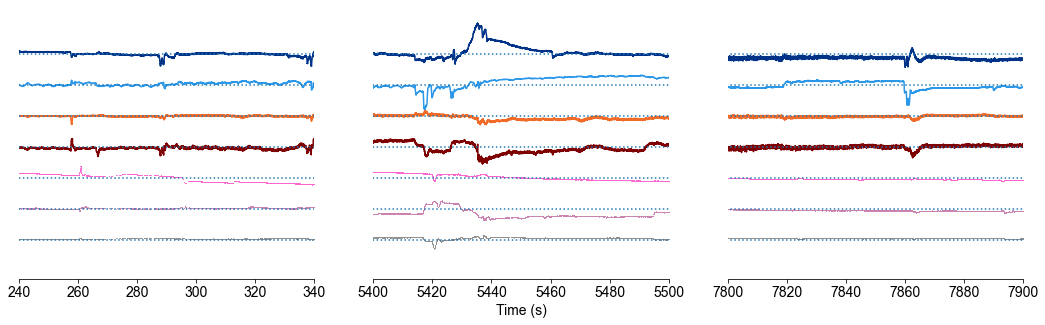

In [16]:
fs = 1000
pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
labels = ['Central', 'Bottom', 'Top Left', 'Top Right', 'Yaw', 'Pitch', 'Roll']
offsets=[]
offsets.append([-0.7,-0.5,-0.2,0.3,-2,0.2,1.4+8*0.8])
offsets.append([1.1,-0.1,0.2,0.5,1,-1.1,1.6+8*0.8])
offsets.append([1.4,-0.3,-0.2,0.3,1,-0.3,8*0.8])

vinterval=2
start=[240,5400,7800]

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=[18, 5])

for ii,ax in enumerate(axes):
    offset=offsets[ii]
    line0 = ax.plot(timestamp_pv, 3*normalize_to_range(pv_c_f)+offset[0]+6*vinterval, c=pv_color[0])
    line1 = ax.plot(timestamp_pv, 3*normalize_to_range(pv_b_f)+offset[1]+5*vinterval, c=pv_color[1])
    line2 = ax.plot(timestamp_pv, 2*normalize_to_range(pv_tl_f)+offset[2]+4*vinterval, c=pv_color[2])
    line3 = ax.plot(timestamp_pv, 4*normalize_to_range(pv_tr_f)+offset[3]+3*vinterval, c=pv_color[3])

    line4 = ax.plot(timestamp_or, 4*normalize_to_range(y_n)+offset[4]+2*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[0], mew=0, ms=1)
    line5 = ax.plot(timestamp_or, 2*p_n+offset[5]+1*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[1], mew=0, ms=1)
    line6 = ax.plot(timestamp_or, 10*r_n+offset[6]+0*vinterval,
                    linestyle='None', marker='o', markerfacecolor=or_color[2], mew=0, ms=1)

    ax.set_ylim([-2.5,15])
    # ax.axis('off')

    ax.set_xlim([start[ii],(start[ii]+100)])
    ax.hlines([0,2,4,6,8,10,12],0,len(y_n),linestyles='dotted')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.get_yaxis().set_visible(False)

axes[1].set_xlabel("Time (s)")
fig.subplots_adjust(hspace=1)
plt.show()
#plt.savefig('../results/fig5/result_9140_to_9150.png')
